In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data_collector import Omie

from potenciala import BucketMethod, Potenciala

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df = pd.read_csv("day_ahead_market_20210707.csv")

### Decide x_value resolution: 0.25 or 1
### Issue with time change: 23, 24 and 25 hours -> Solved through no_time_change parameter

In [5]:
s_1 = Potenciala(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = Potenciala(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

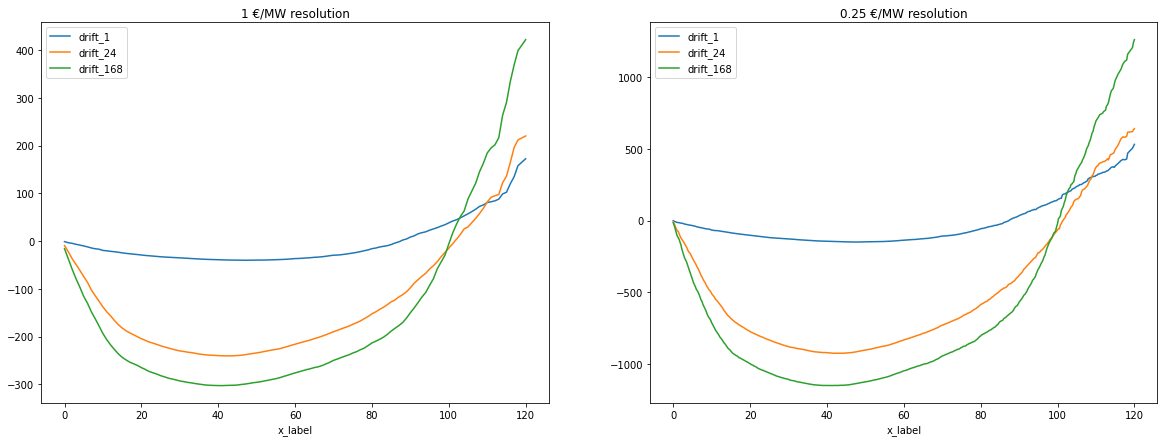

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

In [7]:
s_1.df

,date,hour,year,month,day,portugal,spain,drift_1,drift_24,drift_168,diffusion_1,diffusion_24,diffusion_168,x_label
0,2002-01-01,1,2002.0,1.0,1.0,7.521,45.20,-13.93,10.10,-2.70,194.0449,102.0100,7.2900,45.0
1,2002-01-01,2,2002.0,1.0,1.0,5.203,31.27,-8.53,-0.78,4.42,72.7609,0.6084,19.5364,31.0
2,2002-01-01,3,2002.0,1.0,1.0,3.784,22.74,-1.88,3.38,11.77,3.5344,11.4244,138.5329,23.0
3,2002-01-01,4,2002.0,1.0,1.0,3.471,20.86,-0.34,3.43,13.65,0.1156,11.7649,186.3225,21.0
4,2002-01-01,5,2002.0,1.0,1.0,3.414,20.52,-0.93,2.68,13.99,0.8649,7.1824,195.7201,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171067,2021-07-07,20,2021.0,7.0,7.0,97.000,97.00,3.77,NaN,NaN,14.2129,NaN,NaN,97.0
171068,2021-07-07,21,2021.0,7.0,7.0,100.770,100.77,6.23,NaN,NaN,38.8129,NaN,NaN,101.0
171069,2021-07-07,22,2021.0,7.0,7.0,107.000,107.00,0.70,NaN,NaN,0.4900,NaN,NaN,107.0
171070,2021-07-07,23,2021.0,7.0,7.0,107.700,107.70,-4.05,NaN,NaN,16.4025,NaN,NaN,108.0


### Include all history or last n years

In [ ]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = Potenciala(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
    for ax, col in zip(axis, s_year.drift_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.drift_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2011, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = Potenciala(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.drift_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.drift_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2021, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = Potenciala(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.drift_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.drift_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
foo = df[df["year"] == 2020]

In [ ]:
foo = foo[foo["month"].isin([3,4,10,11])]
foo_34 = foo[foo["month"].isin([3, 4])]
foo_1011 = foo[foo["month"].isin([10, 11])]

In [ ]:
bar = pd.DataFrame()
#bar["date_hour"] = pd.date_range(start="2020-03-01", end="2020-05-01", freq="H")
bar["date_hour"] = pd.date_range(start="2020-10-01", end="2020-12-31", freq="H")
#bar = bar[bar["date_hour"] < "2020-12-01"]

In [ ]:
(pd.to_datetime(df["date"].max()) + pd.Timedelta("1 day")).strftime(format="%Y-%m-%d")

In [ ]:
bar["date"] = bar.date_hour.dt.date.astype(str)
bar["hour"] = (bar.date_hour.dt.hour + 1).astype(int)

In [ ]:
result = bar.merge(foo_1011, how="left", on=["date", "hour"])
result["shift_24"] = result["spain"].shift(-24)
result["drift"] = result["shift_24"] - result["spain"]

In [ ]:
foo_1011.shape

In [ ]:
foo_1011.date.value_counts()

In [ ]:
bar.shape

In [ ]:
result[result["date"] == "2020-10-25"]

In [ ]:
result[result["date"] >= "2020-10-25"].head(48)